In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math
np.random.seed(365)
from numpy import mean
import pickle
import warnings
warnings.filterwarnings("ignore")

import statsmodels.api as sm
from sklearn.metrics import mean_squared_error
from statsmodels.tools.eval_measures import rmse 
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose 
from pmdarima import auto_arima 
from statsmodels.tsa.statespace.sarimax import SARIMAX 



## Read in Dataset:

In [2]:
queens_df = pickle.load(open('./data/final_cleaned_data/queens_cleaned_data.pkl','rb'))
all_df = pickle.load(open('./data/final_cleaned_data/all_cleaned_data.pkl','rb'))


In [3]:
#Queens
queens_precovid_df = queens_df[:'2020-03-21']
queens_covid_df = queens_df['2020-03-21':]
# Import placeholder
placeholder_queens = pickle.load(open('./data/pickled/placeholder_queens.pkl','rb'))
# Test Train Split:
X = queens_precovid_df.values
size = int(len(X) * 0.70)
queens_precovid_train, queens_precovid_test  = queens_precovid_df[:size], queens_precovid_df[size:]
queens_covid_train, queens_covid_test = queens_covid_df[:size], queens_covid_df[size:]


In [4]:
queens_precovid_train

,count
pickup_time,
2019-06-01 00:00:00,724
2019-06-01 01:00:00,481
2019-06-01 02:00:00,206
2019-06-01 03:00:00,106
2019-06-01 04:00:00,164
...,...
2019-12-24 07:00:00,328
2019-12-24 08:00:00,350
2019-12-24 09:00:00,400


## Dickey-Fuller Test:

In [5]:
## CHECK TO SEE IF OUR DATA IS STATINONARY
ad_test = adfuller(queens_precovid_train['count'])
print('ADF Statistic: %f' % ad_test[0])
print('p-value: %f' % ad_test[1])
print('Critical Values:')
for key, value in ad_test[4].items():
    print('\t%s: %.3f' % (key, value))
print('number of observations used:', ad_test[3])
print('lags used:', ad_test[2])

ADF Statistic: -12.281815
p-value: 0.000000
Critical Values:
	1%: -3.432
	5%: -2.862
	10%: -2.567
number of observations used: 4923
lags used: 32


We can see here that our p-value is less than our alpha value and also test statistic is less than the critical value, so we can reject the null hypothesis. (null hypothesis is the data is not stationary). So our data is stationary. We do not need to difference our data.

## ACF AND PACF

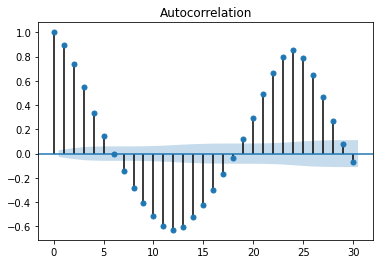

In [6]:
from statsmodels.graphics.tsaplots import plot_acf
plot_acf(queens_precovid_train['count'], alpha=.05, lags=30);

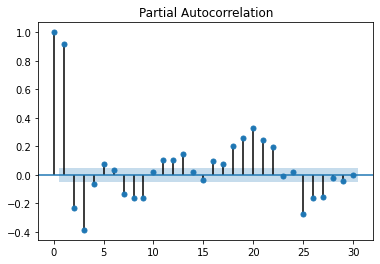

In [7]:
from statsmodels.graphics.tsaplots import plot_pacf
plot_pacf(queens_precovid_test['count'], alpha=.025, lags=30);

ARIMA Model #1:

In [8]:
model = ARIMA(queens_precovid_train, order=(2,0,4))
arima_1 = model.fit(disp=0)
print(arima_1.summary())

                              ARMA Model Results                              
Dep. Variable:                  count   No. Observations:                 4956
Model:                     ARMA(2, 4)   Log Likelihood              -31123.905
Method:                       css-mle   S.D. of innovations            129.136
Date:                Tue, 10 Nov 2020   AIC                          62263.810
Time:                        18:05:59   BIC                          62315.877
Sample:                    06-01-2019   HQIC                         62282.067
                         - 12-24-2019                                         
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const         666.4721      5.393    123.584      0.000     655.902     677.042
ar.L1.count     1.7543      0.012    143.932      0.000       1.730       1.778
ar.L2.count    -0.8219      0.012    -70.085    

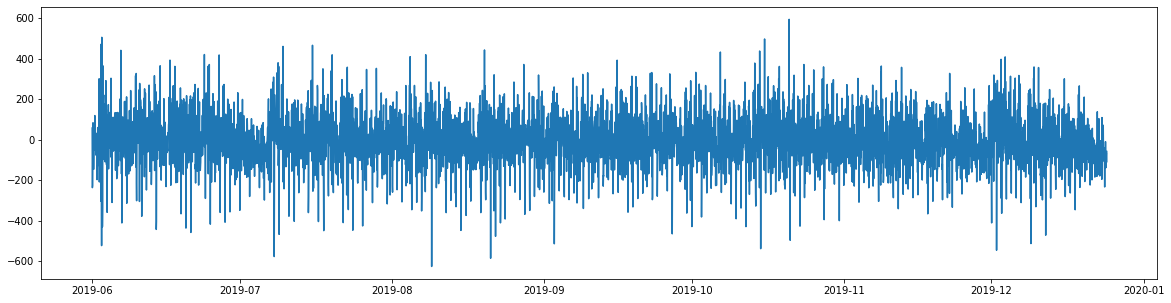

In [9]:
plt.figure(figsize=(20,5))  # plot the residuals

residuals = pd.DataFrame(arima_1.resid)
plt.plot(residuals)
plt.show()

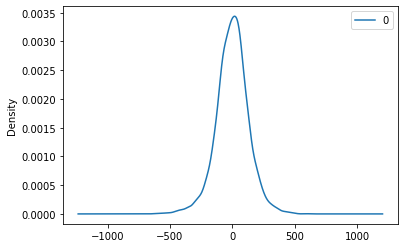

In [10]:
residuals = pd.DataFrame(arima_1.resid)  # plot the residuals distribution
residuals.plot(kind='kde',)
plt.show()

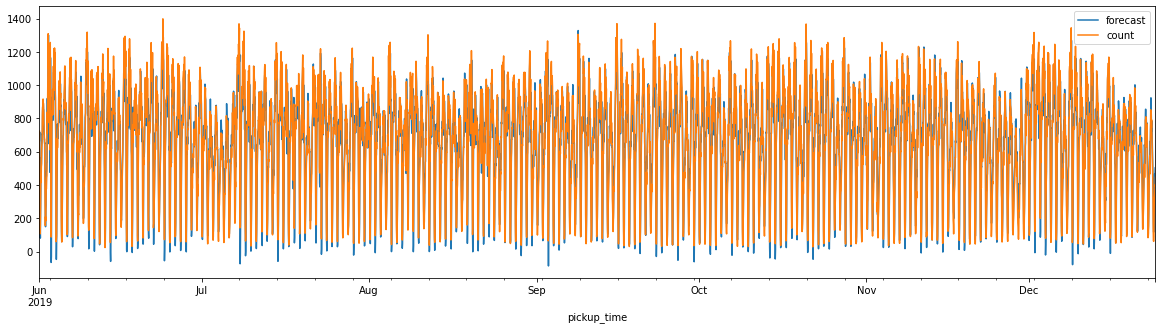

In [11]:
fig, ax = plt.subplots(figsize=(20, 5))
arima_1.plot_predict(ax=ax);

In [12]:
# evaluate the model on the training data
train_arma_rmse = np.sqrt(np.mean(arima_1.resid**2)) 
placeholder_queens['arima_1'] = train_arma_rmse

placeholder_queens

{'naive_forecast_baseline': 299.0312670637179,
 'moving_average_baseline': 297.19129484365396,
 'rmse_holt_linear': 168.71272204761075,
 'rmse_holt_winter': 95.01986406903862,
 'arima_1': 129.15377870468214}

In [13]:
# get predictions for the test data
predictions = arima_1.predict(start=queens_precovid_test.index[0], end=queens_precovid_test.index[-1])
residuals = queens_precovid_test['count'] - predictions  
test_arma_rmse = np.sqrt(np.mean(residuals**2))
print(test_arma_rmse)

332.3303871186909


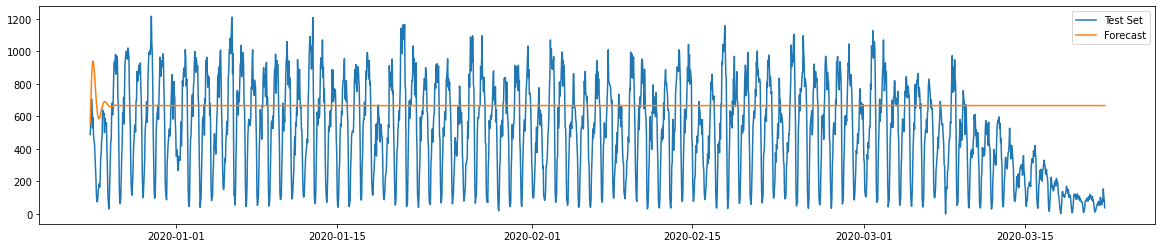

In [14]:
plt.figure(figsize=(20,4)) 

plt.plot(queens_precovid_test)
plt.plot(predictions)

plt.legend(('Test Set', 'Forecast'))

Seems like we are using mean to forecast. This is not ideal as it is only forecasting on the mean

## ARIMA #2 Using auto_arima

In [15]:
stepwise_fit = auto_arima(queens_precovid_df['count'], start_p = 0, start_q = 0, 
                          max_p = 10, max_q = 10, m = 12, 
                          start_P = 0, seasonal = False, 
                          d = None, D = None, trace = True, 
                          error_action ='ignore',   # we don't want to know if an order does not work 
                          suppress_warnings = True,  # we don't want convergence warnings 
                          stepwise = True)           # set to stepwise 
stepwise_fit.summary() 


Fit ARIMA: order=(0, 1, 0); AIC=90099.469, BIC=90113.199, Fit time=0.003 seconds
Fit ARIMA: order=(1, 1, 0); AIC=89751.591, BIC=89772.185, Fit time=0.094 seconds
Fit ARIMA: order=(0, 1, 1); AIC=89849.843, BIC=89870.438, Fit time=0.045 seconds
Fit ARIMA: order=(2, 1, 0); AIC=89522.187, BIC=89549.647, Fit time=0.155 seconds
Fit ARIMA: order=(2, 1, 1); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(3, 1, 1); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(3, 1, 0); AIC=89521.309, BIC=89555.633, Fit time=0.180 seconds
Fit ARIMA: order=(4, 1, 1); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(4, 1, 0); AIC=89389.878, BIC=89431.067, Fit time=0.304 seconds
Fit ARIMA: order=(5, 1, 1); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(5, 1, 0); AIC=89212.534, BIC=89260.588, Fit time=0.398 seconds
Fit ARIMA: order=(6, 1, 1); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(6, 1, 0); AIC=89209.724, BIC=89264.643, Fit time=0.642 seconds
Fit ARIMA: order=

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:                    D.y   No. Observations:                 7079
Model:                ARIMA(10, 1, 0)   Log Likelihood              -44448.399
Method:                       css-mle   S.D. of innovations            129.014
Date:                Tue, 10 Nov 2020   AIC                          88920.798
Time:                        18:06:20   BIC                          89003.177
Sample:                             1   HQIC                         88949.168
                                                                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0969      1.492     -0.065      0.948      -3.021       2.827
ar.L1.D.y      0.1423      0.012     12.076      0.000       0.119       0.165
ar.L2.D.y      0.2333      0.012     19.722      0.000       0.210       0.257
ar.L3.D.y      0.0563      0.012      4.634      0.000       0.032       0.080
ar.L4.D.y     -0.1405      0.012    -11.625      0.000      -0.164      -0.117
ar.L5.D.y     -0.2177      0.012    -17.838      0.000      -0.242      -0.194
ar.L6.D.y      0.0083      0.012      0.682      0.495      -0.016       0.032
ar.L7.D.y      0.1157      0.012      9.571      0.000       0.092       0.139
ar.L8.D.y      0.0172      0.012      1.418      0.156      -0.007       0.041
ar.L9.D.y     -0.1128      0.012     -9.535      0.000      -0.136      -0.090
ar.L10.D.y    -0.1304      0.012    -11.065      0.000      -0.153      -0.107
                                    Roots                                     
==============================================================================
                   Real          Imaginary           Modulus         Frequency
------------------------------------------------------------------------------
AR.1             1.0735           -0.3802j            1.1389           -0.0542
AR.2             1.0735           +0.3802j            1.1389            0.0542
AR.3             0.7629           -0.8623j            1.1513           -0.1347
AR.4             0.7629           +0.8623j            1.1513            0.1347
AR.5            -0.1819           -1.2091j            1.2227           -0.2738
AR.6            -0.1819           +1.2091j            1.2227            0.2738
AR.7            -1.2601           -0.3532j            1.3087           -0.4565
AR.8            -1.2601           +0.3532j            1.3087            0.4565
AR.9            -0.8269           -1.0287j            1.3199           -0.3578
AR.10           -0.8269           +1.0287j            1.3199            0.3578
------------------------------------------------------------------------------
"""

In [16]:
model_2 = SARIMAX(queens_precovid_df['count'], order = (5, 0, 2)) 
  
result = model_2.fit() 
result.summary() 

/anaconda/envs/azureml_py36/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Statespace Model Results                           
==============================================================================
Dep. Variable:                  count   No. Observations:                 7080
Model:               SARIMAX(5, 0, 2)   Log Likelihood              -44277.339
Date:                Tue, 10 Nov 2020   AIC                          88570.679
Time:                        18:06:32   BIC                          88625.599
Sample:                    06-01-2019   HQIC                         88589.592
                         - 03-21-2020                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          2.5085      0.012    207.017      0.000       2.485       2.532
ar.L2         -2.4094      0.030    -79.889      0.000      -2.469      -2.350
ar.L3          0.6534      0.039     16.812      0.000       0.577       0.730
ar.L4          0.4876      0.030     16.023      0.000       0.428       0.547
ar.L5         -0.2514      0.012    -20.806      0.000      -0.275      -0.228
ma.L1         -1.3756      0.006   -246.336      0.000      -1.387      -1.365
ma.L2          0.9726      0.005    183.668      0.000       0.962       0.983
sigma2      1.713e+04    264.812     64.673      0.000    1.66e+04    1.76e+04
===================================================================================
Ljung-Box (Q):                     3377.03   Jarque-Bera (JB):              1099.17
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.55   Skew:                            -0.61
Prob(H) (two-sided):                  0.00   Kurtosis:                         4.50
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [ ]:
start = len(queens_precovid_train) 
end = len(queens_precovid_train) + len(queens_precovid_test) - 1
  
# Predictions for one-year against the test set 
predictions = result.predict(start, end, 
                             typ = 'levels').rename("Predictions") 
  
# plot predictions and actual values 
fig, ax = plt.subplots(figsize=(20, 5))
predictions.plot(legend = True) 
queens_precovid_test['count'].plot(legend = True) 
plt.title('Forecasting from December 24th to March 21st (before Covid Lockdown)')
predictions

In [18]:
# Calculate root mean squared error 
print('RMSE for ARIMA#2:' ,rmse(queens_precovid_test["count"], predictions) )

placeholder_queens['arima_2'] = rmse(queens_precovid_test["count"], predictions) 
placeholder_queens

RMSE for ARIMA#2: 102.45829569543865


{'naive_forecast_baseline': 299.0312670637179,
 'moving_average_baseline': 297.19129484365396,
 'rmse_holt_linear': 168.71272204761075,
 'rmse_holt_winter': 95.01986406903862,
 'arima_1': 129.15377870468214,
 'arima_2': 102.45829569543865}

Holt Winter is still giving best RMSE score.  We can try to add seasonality to see if that could improve our score.

## SARIMA 

In [21]:
import pmdarima as pm

sarima_1 = auto_arima(queens_precovid_df['count'], start_p = 1, start_q = 1, 
                          max_p = 3, max_q = 3, m = 24, 
                          start_P = 0, seasonal = True, 
                          d = None, D = 1, trace = True, 
                          error_action ='ignore',   # we don't want to know if an order does not work 
                          suppress_warnings = True,  # we don't want convergence warnings 
                          stepwise = True)           # set to stepwise 

sarima_1.summary()

Fit ARIMA: order=(1, 0, 1) seasonal_order=(0, 1, 1, 24); AIC=83238.156, BIC=83272.464, Fit time=228.233 seconds
Fit ARIMA: order=(0, 0, 0) seasonal_order=(0, 1, 0, 24); AIC=92204.403, BIC=92218.127, Fit time=1.018 seconds
Fit ARIMA: order=(1, 0, 0) seasonal_order=(1, 1, 0, 24); AIC=85620.195, BIC=85647.642, Fit time=169.726 seconds
Fit ARIMA: order=(0, 0, 1) seasonal_order=(0, 1, 1, 24); AIC=86158.828, BIC=86186.275, Fit time=201.173 seconds
Fit ARIMA: order=(1, 0, 1) seasonal_order=(1, 1, 1, 24); AIC=83203.312, BIC=83244.481, Fit time=292.118 seconds


In [ ]:
sarima_model = SARIMAX(queens_precovid_train, order=(3, 0, 1), seasonal_order=(2, 1, 0, 8))
result = sarima_model.fit()

In [ ]:
result.summary()

In [ ]:
start = len(queens_precovid_train) 
end = len(queens_precovid_train) + len(queens_precovid_test) - 1
  
# Predictions for one-year against the test set 
predictions = result.predict(start, end, 
                             typ = 'levels').rename("Predictions") 
  
# plot predictions and actual values 
predictions.plot(legend = True) 
queens_precovid_test['count'].plot(legend = True) 

In [51]:
rmse(queens_precovid_test['count'], predictions) 

297.6459488994467

/anaconda/envs/azureml_py36/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


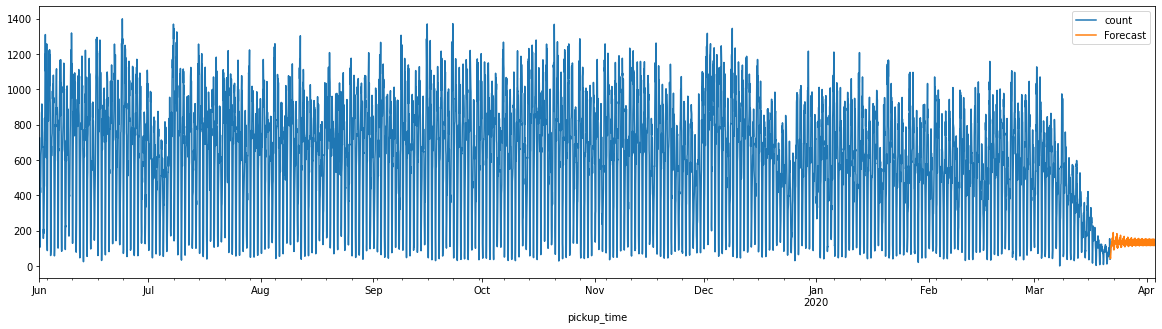

In [53]:
# Train the model on the full dataset 
model = SARIMAX(queens_precovid_df['count'],  
                        order=(3, 0, 1), seasonal_order=(2, 1, 0, 8)) 
result = model.fit() 
  
# Forecast for the next 3 months 
forecast = result.predict(start = len(queens_precovid_df),  
                          end = (len(queens_precovid_df)-1) + 300,  
                          typ = 'levels').rename('Forecast') 
  
# Plot the forecast values 
queens_precovid_df['count'].plot(figsize = (20, 5), legend = True) 
forecast.plot(legend = True) 

### NEW SARIMA MODEL

In [54]:
sarima_model_3 = SARIMAX(queens_precovid_train, order=(3, 0, 1), seasonal_order=(2, 1, 0, 8))  # define model
sarima_3 = sarima_model_3.fit()  


/anaconda/envs/azureml_py36/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


dadasda

In [18]:
import pmdarima as pm

# Seasonal - fit stepwise auto-ARIMA
smodel_1 = pm.auto_arima(queens_precovid_train, start_p=1, start_q=1,
                         test='adf',
                         max_p=3, max_d = 3, max_q=3, m=24,
                         max_P=3, max_D=3, max_Q=3,
                         start_P=0, seasonal=True,
                         d=None, D=1, trace=True,
                         error_action='ignore',  
                         suppress_warnings=True, 
                         stepwise=True)

smodel_1.summary()

Fit ARIMA: order=(1, 0, 1) seasonal_order=(0, 1, 1, 24); AIC=58730.260, BIC=58762.778, Fit time=180.073 seconds
Fit ARIMA: order=(0, 0, 0) seasonal_order=(0, 1, 0, 24); AIC=64921.167, BIC=64934.174, Fit time=0.811 seconds
Fit ARIMA: order=(1, 0, 0) seasonal_order=(1, 1, 0, 24); AIC=60429.179, BIC=60455.193, Fit time=105.082 seconds
Fit ARIMA: order=(0, 0, 1) seasonal_order=(0, 1, 1, 24); AIC=60560.448, BIC=60586.462, Fit time=101.154 seconds
Fit ARIMA: order=(1, 0, 1) seasonal_order=(1, 1, 1, 24); AIC=58818.926, BIC=58857.947, Fit time=291.015 seconds
Fit ARIMA: order=(1, 0, 1) seasonal_order=(0, 1, 0, 24); AIC=61445.137, BIC=61471.151, Fit time=3.698 seconds


In [ ]:
smodel_1